In [55]:
# please read README file before start
#

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 

import gmplot

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor

import scipy.stats as stat
from IPython.core.display import HTML,display
import webbrowser,os

In [2]:
# function of data clean and engineer

def clean_data(df_input):
    '''
    clean the data : remove NaN value 
    
    1, remove columns 'Ehail_fee' since it's all NaN value
    2, replace NaN value in column 'Trip_type' by most frequent value 1.0
    '''
    df_input=df_input.drop(['Ehail_fee'],axis=1)
    df_input['Trip_type ']=df_input['Trip_type '].fillna(value=1.0)
    
    return df_input

def feature_eng(df_input):
    '''
    feature engineer for Question 4:
    1, convert object column 'Store_and_fwd_flag' column into number;
    2, convert pickup/drop date into datetime type
    3, create new feature tip/total fare, the weekday of pick up and hours of pickup and total time used for travel
    '''
    Lb=LabelEncoder()
    df_input['Store_and_fwd_flag_label_label']=Lb.fit_transform(df['Store_and_fwd_flag'])
    
    df_input['pickup_hour']=pd.to_datetime(df_input['lpep_pickup_datetime']).apply(lambda x: x.hour)
    df_input['pickup_weekday']=pd.to_datetime(df_input['lpep_pickup_datetime']).apply(lambda x: x.weekday())

    df_input['tip_over_fare(%)']=list(map(lambda x : x[0]/x[1]*100 if x[1]!=0.0 else 0.0, df_input[['Tip_amount','Total_amount']].values))
    
    df_output=df_input.drop(['lpep_pickup_datetime','Lpep_dropoff_datetime','Store_and_fwd_flag'],axis=1)
    
    
    
    return df_output



def speed_feature(df_input):
    '''
    Create the feature speed, weeks of month and hour of day
    
    '''
    
    dropoff_time=pd.to_datetime(df_input['Lpep_dropoff_datetime'])
    pickup_time=pd.to_datetime(df_input['lpep_pickup_datetime'])
    df_input['trip_time']=list(map(lambda x,y: x-y,dropoff_time,pickup_time))
    df_input['trip_time_seconds']=df_input['trip_time'].apply(lambda x:x.total_seconds())
    df_input['speed']=list(map(lambda x : x[0]/x[1] if x[1]!=0.0 else 0.0, df_input[['Trip_distance','trip_time_seconds']].values))
    
    df_input['week_of_month']=pd.to_datetime(df_input['lpep_pickup_datetime']).apply(lambda x:x.week)
    df_input['day_of_month']=pd.to_datetime(df_input['lpep_pickup_datetime']).apply(lambda x:x.day)
    
    df_output=df_input.drop(['trip_time','trip_time_seconds'],axis=1)
    
    return df_output

In [3]:
# function of plot 
def plot_location_google_map(df_jfk,outfile):
    '''
    plot location of pickup on google map
    
    The input dataframe must contain pickup and drop off coordiante
    
    '''
    
    JFK_coord=[40.6413,-73.7781]
    
    # Check the location of pick_up for Trip terminated at JFK airport 
    jfk_plot=gmplot.GoogleMapPlotter(JFK_coord[0],JFK_coord[1],10)
    if df_jfk.shape[0]<10000:
        jfk_plot.scatter(np.array(df_jfk.Pickup_latitude),np.array(df_jfk.Pickup_longitude),'# FF0000',
                     size = 20, marker = False)
    else:
        jfk_plot.heatmap(np.array(df_jfk.Pickup_latitude),np.array(df_jfk.Pickup_longitude))

    #s save plot on disk
    outpath='map_jfk_{}.html'.format(outfile)
    jfk_plot.draw(outpath)

    # Open the plot at default browser
    webbrowser.open('map_jfk_{}.html'.format(outfile),new=2)
    
def plot_trip_payment_type(df_jfk):
    plot_column = ['Payment_type','Trip_type ']

    plt.figure(figsize=(12,4))
    for i, column in enumerate(plot_column):
        Value_count=df_jfk[column].value_counts()
        label=Value_count.index
        label=list(map(lambda x: 'Type '+str(x),label))

        count=Value_count.values  

        plt.subplot(1,2,i+1)
        plt.pie(count,labels=label,autopct='%1.1f%%');
        plt.title(column)

def plot_trip_distance(trip_distance):
    '''
    plot histogram of trip_distance 
    
    '''
    plt.figure(figsize=(18,6))
    plt.subplot(121)
    plt.hist(trip_distance,bins=300);
    plt.xlabel('Trip_distance')
    plt.ylabel('Counts')
    plt.title('Plot of Trip_distance of all')

    plt.subplot(122)
    plt.hist(trip_distance,bins=300,range=(0,30));
    plt.xlabel('Trip_distance')
    plt.ylabel('Counts')
    plt.title('Plot of Trip_distrance between 0~30')

def passenger_count_plot(df_jfk):
    jfk_pass_count=df_jfk.groupby('Passenger_count').count()
    jfk_pass_mean=df_jfk.groupby('Passenger_count').mean()

    print('The count of passenger_count is 8 is {}'.format(jfk_pass_count[jfk_pass_count.index==8]['Trip_distance'].values))

    print('---------------------------------------------')

    plt.figure(figsize=(9,3))
    plt.subplot(121)
    plt.bar(jfk_pass_count.index,jfk_pass_count['Trip_distance']);
    plt.xlabel('Passenger_count')
    plt.ylabel('number')
    plt.title('bar plot')

    plt.subplot(122)
    plt.scatter(jfk_pass_count.index,jfk_pass_mean['Trip_distance']);
    plt.xlabel('Passenger_count')
    plt.ylabel('Average trip distance')
    plt.title(' averaged trip distance for each passenger_count');
    
def plot_speed_time_location(df_input):
    
    speed_slow=df_input[df_input['speed']<7/3600]
    speed_medium=df_input[(df_input['speed']>7/3600) & (df_input['speed']<=20/3600)]
    speed_fast=df_input[df_input['speed']>20/3600]

    variable=['Pickup_latitude','Pickup_longitude','Dropoff_latitude','Dropoff_longitude','pickup_hour']
    plt.figure(figsize=(20,12))
    for i,string in enumerate(variable):
              

        x=[speed_slow[string],speed_medium[string],speed_fast[string]]
        labels=['slow speed','medium speed','fast speed']
        colors=['red','yellow','blue']
        if string!='pickup_hour':
            min_r=df_input[string].median()-0.3;
            max_r=df_input[string].median()+0.3;
        else:
            min_r=df_input[string].min()-0.3;
            max_r=df_input[string].max()+0.3  ;          
        plt.subplot(3,2,i+1)
        plt.hist(x,bins=20,range=(min_r,max_r),label=labels,color=colors);
        plt.xlabel(string,size=14)
        plt.ylabel('count')
        plt.legend()


In [4]:
# function of model 
def linear_model(x,y):
    '''
    linear regression model from sklean package
    ''' 
    global train_x,train_y,test_x,test_y
    
    LR=LinearRegression()
    LR.fit(train_x,train_y)

    y_pre_LR=LR.predict(test_x)    # prediction from linear regression 

    score_lr=cross_val_score(LR,x,y,cv=5,scoring='neg_mean_squared_error')

    print('Score of 5 fold cross validation of linear regression model {}'.format(score_lr))
    
    return y_pre_LR
    
def lasso_model(x,y):
    '''
    Lasso regression model from sklean package
    '''
    # Lasso 
    global train_x,train_y,test_x,test_y
    
    ls=Lasso(alpha=0.7)
    ls.fit(train_x,train_y)
    score_ls=cross_val_score(ls,x,y,cv=5,scoring='neg_mean_squared_error')
    print('Score of 5 fold cross validation of Lasso regression model {}'.format(score_ls))

    
def Randomforest_model(x,y,cvn):
    '''
    Randomforest regression model from sklean package
    
    '''
    global train_x,train_y,test_x,test_y
    
    # Random forest regressor model 
    RF=RandomForestRegressor(n_estimators=10,criterion='mse')
    RF.fit(train_x,train_y.ravel())
    y_pre_rf=RF.predict(test_x)    # prediction from randomforest regression 


    score_rf=cross_val_score(RF,x,y.ravel(),cv=cvn,scoring='neg_mean_squared_error')
    print('Score of {} fold of cross validation of Randomforest regression model {}'.format(cvn,score_rf))
    
    return y_pre_rf, RF

In [5]:
# function of test 

def mean_test(week1,week2,week3,week4,week5,p_value):
    '''
    # The hypothesis H0: the mean of all weeks are same
    # test:    one-way ANOVA 
    '''

    Hypothesis='H0: the mean of all weeks are same'
    oneway_ANOVA=stat.f_oneway(week1,week2,week3,week4,week5)
    p_value=0.05
    if oneway_ANOVA[1]>p_value:
        print('Reject the hypothesis: {}'.format(Hypothesis))
    else:
        print('Accept the hypothesis: {}'.format(Hypothesis))

## Question 1: 
•             Programmatically download and load into your favorite analytical tool the trip data for September 2015.

•             Report how many rows and columns of data you have loaded.

In [6]:
#os.system('wget https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv')

download_command='wget https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv'

print('The command of download data is "{}"'.format(download_command))

The command of download data is "wget https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"


In [7]:
# download data with wget command : 
df=pd.read_csv('green_tripdata_2015-09.csv')


In [8]:
df.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979485,40.684956,-73.979431,40.685020,1,...,7.8,0.0,0.0,1.95,0.0,NaN,0.0,9.75,1,2.0
1,2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010796,40.912216,-74.010780,40.912212,1,...,45.0,0.0,0.0,0.00,0.0,NaN,0.0,45.00,1,2.0
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,...,4.0,0.5,0.5,0.50,0.0,NaN,0.3,5.80,1,1.0
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921387,40.766678,-73.931427,40.771584,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482,40.714046,-73.944412,40.714729,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0


In [9]:
print('The total rows of data is    :{}'.format(df.shape[0]))
print('The total columns of data is :{}'.format(df.shape[1]))

The total rows of data is    :1494926
The total columns of data is :21


In [10]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type '],
      dtype='object')

In [11]:
df.dtypes

VendorID                   int64
lpep_pickup_datetime      object
Lpep_dropoff_datetime     object
Store_and_fwd_flag        object
RateCodeID                 int64
Pickup_longitude         float64
Pickup_latitude          float64
Dropoff_longitude        float64
Dropoff_latitude         float64
Passenger_count            int64
Trip_distance            float64
Fare_amount              float64
Extra                    float64
MTA_tax                  float64
Tip_amount               float64
Tolls_amount             float64
Ehail_fee                float64
improvement_surcharge    float64
Total_amount             float64
Payment_type               int64
Trip_type                float64
dtype: object

In [12]:
df.isnull().sum()

VendorID                       0
lpep_pickup_datetime           0
Lpep_dropoff_datetime          0
Store_and_fwd_flag             0
RateCodeID                     0
Pickup_longitude               0
Pickup_latitude                0
Dropoff_longitude              0
Dropoff_latitude               0
Passenger_count                0
Trip_distance                  0
Fare_amount                    0
Extra                          0
MTA_tax                        0
Tip_amount                     0
Tolls_amount                   0
Ehail_fee                1494926
improvement_surcharge          0
Total_amount                   0
Payment_type                   0
Trip_type                      4
dtype: int64

In [13]:
print('The columns "Ehail_fee" are all NaN value')
print('The columns "Trip_Type" have 4 NaN value')

The columns "Ehail_fee" are all NaN value
The columns "Trip_Type" have 4 NaN value


In [14]:
df=clean_data(df)  # remove NaN value

df.isnull().sum()   # check if there is any NaN value left 

VendorID                 0
lpep_pickup_datetime     0
Lpep_dropoff_datetime    0
Store_and_fwd_flag       0
RateCodeID               0
Pickup_longitude         0
Pickup_latitude          0
Dropoff_longitude        0
Dropoff_latitude         0
Passenger_count          0
Trip_distance            0
Fare_amount              0
Extra                    0
MTA_tax                  0
Tip_amount               0
Tolls_amount             0
improvement_surcharge    0
Total_amount             0
Payment_type             0
Trip_type                0
dtype: int64

## Question 2:
•             Plot a histogram of the number of the trip distance (“Trip Distance”).

•             Report any structure you find and any hypotheses you have about that structure

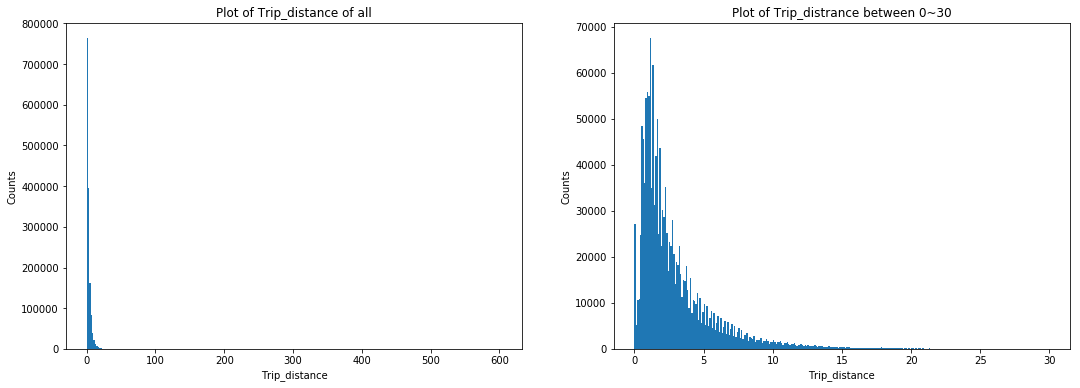

In [15]:
plot_trip_distance(trip_distance=df['Trip_distance'].values)

In [16]:
print('The mean of Trip_distance               is {0:.2f}'.format(df['Trip_distance'].mean(),))
print('The median of Trip_distance             is {0:.2f}'.format(df['Trip_distance'].median()))
print('The standard deviation of Trip_distance is {0:.2f}'.format(df['Trip_distance'].std()))


count_10=len(df[df['Trip_distance']<10])
count_5=len(df[df['Trip_distance']<5])
count_all=len(df['Trip_distance'])

print('Percentage of Trip_distrance < 10 is {0:.2f}'.format(count_10/count_all))
print('Percentage of Trip_distrance < 5 is {0:.2f}'.format(count_5/count_all))

The mean of Trip_distance               is 2.97
The median of Trip_distance             is 1.98
The standard deviation of Trip_distance is 3.08
Percentage of Trip_distrance < 10 is 0.96
Percentage of Trip_distrance < 5 is 0.84


## Comments:
The distribution of Trip_distrance is positive skewed. 96% of the trip distance is small than 10 and 84% of the trip distance is 
smaller than 5. So the majority of trip is short trip. which make sence since most of people using taxi for convinence and emergency. 

## Question 3
 3.1 •             Report mean and median trip distance grouped by hour of day.

In [17]:
pick_date=pd.to_datetime(df['lpep_pickup_datetime'])

In [18]:
# build a new variable : hour of the day 
df['pickup_hour']=pick_date.apply(lambda x: x.hour)

In [19]:
trip_hour=df[['pickup_hour','Trip_distance']]
trip_hour_mean=trip_hour.groupby('pickup_hour').mean()
trip_hour_median=trip_hour.groupby('pickup_hour').median()

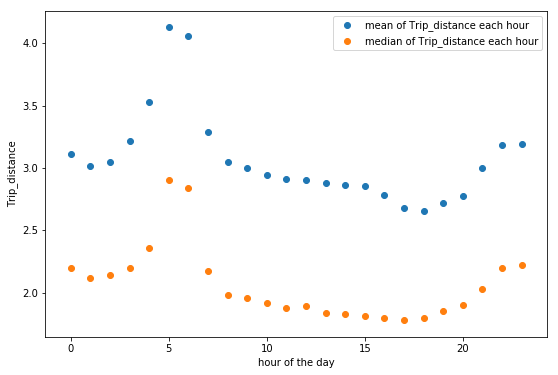

In [20]:
plt.figure(figsize=(9,6))
plt.scatter(trip_hour_mean.index,trip_hour_mean.Trip_distance,label='mean of Trip_distance each hour')
plt.scatter(trip_hour_median.index,trip_hour_median.Trip_distance,label='median of Trip_distance each hour')
plt.xlabel('hour of the day')
plt.ylabel('Trip_distance')
plt.legend()

## Comments:
 1,The mean and median trip distance of each hour are quite consistent. 
 
 2,The peak of Trip_distance appear between 4am-7am; which is the time of public transit stop service or served less frequently. Then trip distance start decreasing. At 17pm, the averaged trip distance is shortest. The 17 pm is the time people get off the work. After 19pm, the trip distance start increasing till 4am of next day. 
 
 3,The interesting thing is that the average trip distance of get off work (around 17 pm) is smaller than of went to work (around 8am~9am). My hypothesis is that customer took taxi might go to bar/restraunt for relaxing instead of back home directly. since Entertainment places are much closer to work place than house. so the trip distance is smaller.  

 3.2 Analysis of trips that originate or terminate at one of the NYC JFK airports

In [21]:
# coordianate of JFK airport:
JFK_coord=[40.6413,-73.7781]


# the pickup and dropoff location should be in the range of 0.01 degree of air-port location
df_jfk=df[((abs(df['Pickup_longitude']-JFK_coord[1])<0.01) & abs((df['Pickup_latitude']-JFK_coord[0])<0.01))  
        | ((abs(df['Dropoff_longitude']-JFK_coord[1])<0.01) & abs((df['Dropoff_latitude']-JFK_coord[0])<0.01))]
jfk_ori=df[((abs(df['Pickup_longitude']-JFK_coord[1])<0.01) & abs((df['Pickup_latitude']-JFK_coord[0])<0.01)) ]
jfk_ter=df[((abs(df['Dropoff_longitude']-JFK_coord[1])<0.01) & abs((df['Dropoff_latitude']-JFK_coord[0])<0.01))]


print ('There are {} records about Trip originated at JFK ariport'.format(jfk_ori.shape[0]))
print ('There are {} records about Trip terminated at JFK ariport'.format(jfk_ter.shape[0]))
print ('There are total {} records related with JFK airport'.format(df_jfk.shape[0]))

There are 188 records about Trip originated at JFK ariport
There are 8614 records about Trip terminated at JFK ariport
There are total 8689 records related with JFK airport


In [22]:
# check the Fare_amount 
jfk_mean=df_jfk.Fare_amount.mean()
print('The average of Fare_amount related with JFK airport is {0:.2f}'.format(jfk_mean))

The average of Fare_amount related with JFK airport is 41.68


In [54]:
# plot pickup location of the trip that realted with JFK airport 
plot_location_google_map(df_jfk,'jfk')

## Comments:
1, The average fare amount of trip related with JFK ariport is 41.68

2, The number of trip terminated at JFK airport is much larger than originated at JFK airport. so it's more prefered to take 
taxi to JFK airport than leave airport 

2, For trip terminated at JFK ariport, The first 3 pickup location are the upper Manhattan, Brooklyn and williamsburg(see map:map_jfk.html); The interesting fact is that there is no records at the downtown and lower Manhattan. 

Text(0.5,1,'Histgram of Fare_amount')

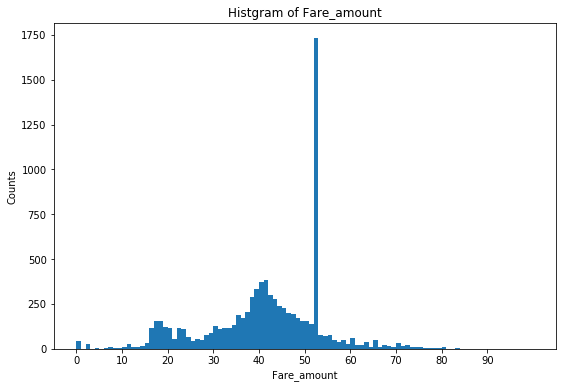

In [24]:
plt.figure(figsize=(9,6))
plt.hist(df_jfk.Fare_amount,bins=100,range=(0,100));
plt.xlabel('Fare_amount')
plt.xticks(range(0,100,10))
plt.ylabel('Counts')
plt.title('Histgram of Fare_amount')

## Comments:
   For trip related with JFK airport,  the Fare amoutn is not Gaussian distributed. Besides the extreme large number of value between 51~53. there are two peak for Fare_amount distribution:one is at 18 fare, The other is at 42 fare; The percentage of Fare amount beyong 60 is vary small 

Text(0.5,1,'Histogram of pickup hour for trip to JFK airport')

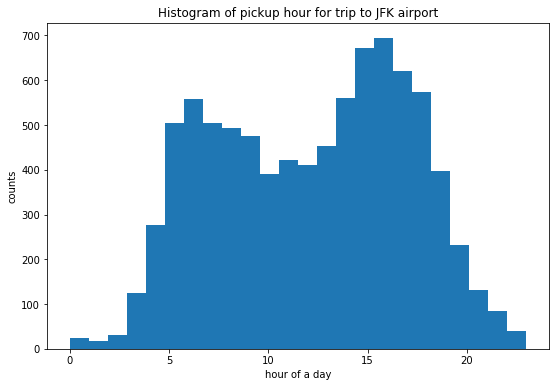

In [25]:
plt.figure(figsize=(9,6))
plt.hist(df_jfk['pickup_hour'],bins=24);
plt.xlabel('hour of a day')
plt.ylabel('counts')
plt.title('Histogram of pickup hour for trip to JFK airport')


## Comments: 
For trip related with JFK airport, most of pick up happened between 4am-21pm. And there are two peak: one is at 6am~9am and the other is at 15pm~18pm. The second peak are quite closed to hotel check out time. 

The count of passenger_count is 8 is [1]
---------------------------------------------


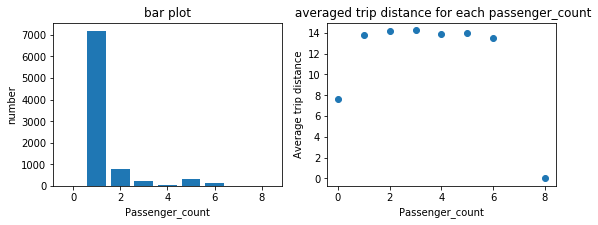

In [26]:
passenger_count_plot(df_jfk)

## Comments: 
1,The plot above show that most of trip only have 1 passenger; 

2, The trip distance is quite same for different passenger_count; so there two feature are not related

3, There are only one record about passenger_count is 8, and trip distance is 0, so this might be anomal sample

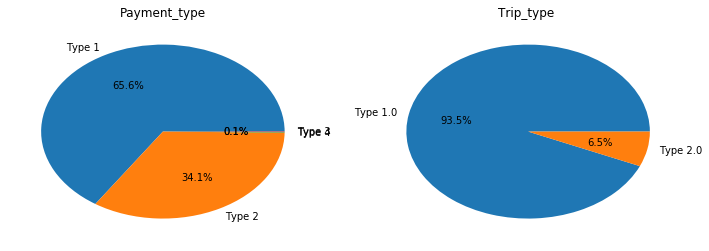

In [27]:
## plot Payment type and Trip type
plot_trip_payment_type(df_jfk)

## Comments:
 1, 66% trip were paid with Type 1, 34.1% trip paid with Type 2 method. 
 
 2, 93.5% of trip belong to Type 1.0 and only 6.5% trip belong to Type 2.0.

## Question 4: 
•             Build a derived variable for tip as a percentage of the total fare.

•             Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). Provide an estimate of performance using an appropriate sample, and show your work.

In [28]:
# build tip percentage of the total fare 
df_feature=feature_eng(df)

In [29]:
# divide data into feature and target 
y=df_feature.iloc[:,-1].values.reshape(-1,1)
x=df_feature.iloc[:,:-1].values

In [30]:
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.2,random_state=100)

In [31]:
y_pre_LR=linear_model(x,y)

Score of 5 fold cross validation of linear regression model [-17.70707986 -17.42970584 -17.23000114 -20.20340149 -17.20936483]


In [32]:
lasso_model(x,y)

Score of 5 fold cross validation of Lasso regression model [-19.68383814 -19.53887998 -19.49299536 -23.66933348 -19.57170245]


In [33]:
y_pre_rf, RF=Randomforest_model(x,y,5)

Score of 5 fold of cross validation of Randomforest regression model [-0.07288399 -0.01764655 -0.02868336 -0.01079953 -0.0310289 ]


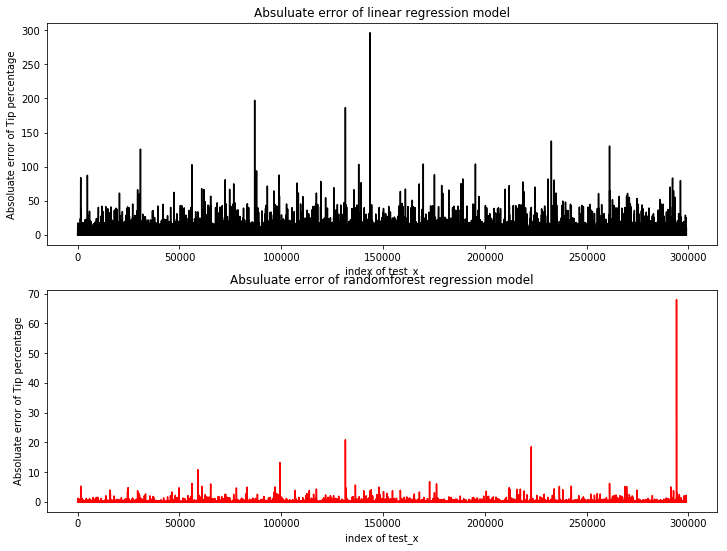

In [34]:
plt.figure(figsize=(12,9))
plt.subplot(2,1,1)
plt.plot(range(298986),abs(test_y-y_pre_LR),color='black')
plt.xlabel('index of test_x')
plt.ylabel('Absoluate error of Tip percentage')
plt.title('Absuluate error of linear regression model')


plt.subplot(2,1,2)
plt.plot(range(298986),abs(test_y-y_pre_rf.reshape(-1,1)),color='red')
plt.xlabel('index of test_x')
plt.ylabel('Absoluate error of Tip percentage')
plt.title('Absuluate error of randomforest regression model');

Text(0.5,1,'Histgram of tip percentage')

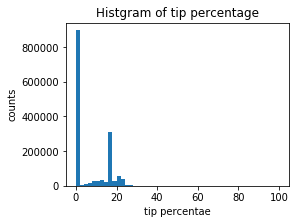

In [35]:
plt.figure(figsize=(4,3))
plt.hist(df_feature['tip_over_fare(%)'],bins=50)
plt.xlabel('tip percentae')
plt.ylabel('counts')
plt.title('Histgram of tip percentage')

In [36]:
# The plot of randomforest error show that there are one sample of predict error is much larger than average error  
# so check  whether the largest error caused by anomal data or model 

#check the largest predict error from Randomforest model 

error_rf=abs(test_y-y_pre_rf.reshape(-1,1))
index_large_error=[]
for i in range(len(error_rf)):
    if error_rf[i]>40:
        index_large_error.append(i)
        
feature=df_feature.columns
feature_number=test_x[index_large_error[0]]
print('largest mispredict test sample')
for i in range(7,13):
    print('The {} is {}'.format(feature[i],feature_number[i]))

largest mispredict test sample
The Trip_distance is 9.7
The Fare_amount is 0.0
The Extra is 0.0
The MTA_tax is 0.0
The Tip_amount is 1.1
The Tolls_amount is 5.54


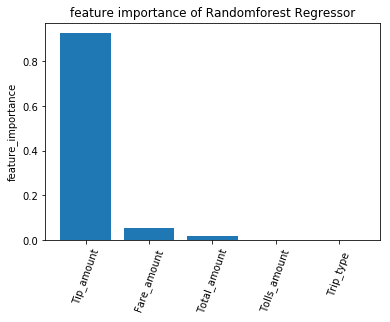

In [37]:
# check feature importance 

feature_importance=pd.DataFrame({'feature':df_feature.columns[:-1],'feature_importance':RF.feature_importances_})
sort_feature=feature_importance.sort_values(by=['feature_importance'],ascending=False)[:5]


plt.bar(range(1,len(sort_feature.feature)+1),sort_feature.feature_importance, align='center')
plt.ylabel('feature_importance')
plt.title('feature importance of Randomforest Regressor')
ax=plt.gca()
ax.set_xticks(range(1,len(sort_feature.feature)+1))
ax.set_xticklabels(sort_feature.feature,rotation=70);

## Comments: 
1, The error of tip percentage for linear regression model is around 17% except 4th fold is 20%

2, The error of tip percentage for randomforest regression model is around 2% except 1st fold is 8%

3, So the randomforest regression model perform better than linear regression model. The reason is that the variable of tip over 
fare percentage is not Gaussion distributed. So i choose Randomforest regressor model 

4, Based on cross validation results, the randomforest model is stable, and not over fit. 

5, The redual plot show that there are one huge error for Randomforest regression model. For this sample(output of in[37]), the trip distance is 9.7 which is larger than 96% of the trip_distance, while the fare only 0.0. So i conclude this smaple are anomal 

6, The first 3 features based on importance are Tip_amount, Fare_amount, Total_amount, 

## Question 5: 
•             Option A: Distributions

•             Build a derived variable representing the average speed over the course of a trip.

•             Can you perform a test to determine if the average trip speeds are materially the same in all weeks of September? If you decide they are not the same, can you form a hypothesis regarding why they differ?

•             Can you build up a hypothesis of average trip speed as a function of time of day

In [38]:
# build the variable:speed, the units is units of trip_distance/second

df_speed=speed_feature(df)

In [39]:
# divide the september into 5 group based on week of the year

week1=df_speed['speed'][df_speed['week_of_month']==36]
week2=df_speed['speed'][df_speed['week_of_month']==37]
week3=df_speed['speed'][df_speed['week_of_month']==38]
week4=df_speed['speed'][df_speed['week_of_month']==39]
week5=df_speed['speed'][df_speed['week_of_month']==40]

In [40]:
mean_test(week1,week2,week3,week4,week5,0.05)

Reject the hypothesis: H0: the mean of all weeks are same


In [41]:
weeks=['1st','2nd','3rd','4th','5th']
for i in range(5):
    print('The mean speed of {0} week is {1:.4f}'.format(weeks[i],df_speed['speed'][df_speed['week_of_month']==(i+36)].mean()))

The mean speed of 1st week is 0.0044
The mean speed of 2nd week is 0.0043
The mean speed of 3rd week is 0.0042
The mean speed of 4th week is 0.0045
The mean speed of 5th week is 0.0047


## Comment:
1,The One-way ANOVA test show that mean of the speed of all weeks of september are different.

2,The speed of all weeks of september are different. The speed of 2nd and 3rd of week are smaller than other weeks.  The 2nd week 
 have holiday like Labor day, 9-11 memorial day, i assume the holiday might be one reason of low average speed. as figure below ('average speed of each day of Septemper') show that at 9-10 and 9-11 (9-11 memorial day), the average speed is lowest 

Text(0.5,1,'average speed of each day of Septemper')

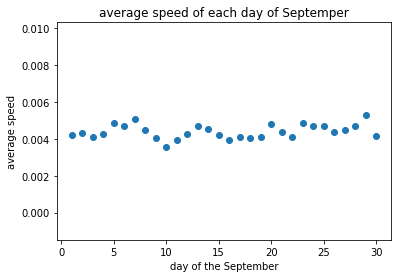

In [42]:
day_speed=df_speed[['day_of_month','speed']].groupby('day_of_month').mean()

plt.scatter(day_speed.index,day_speed.speed)
ymin=min(day_speed.speed)-0.005
ymax=max(day_speed.speed)+0.005
plt.ylim([ymin,ymax])
plt.xlabel('day of the September')
plt.ylabel('average speed')
plt.title('average speed of each day of Septemper')

In [43]:
speed_week=df_speed[['pickup_hour','speed']]

swm=speed_week.groupby('pickup_hour').mean()

Text(0.5,1,'Mean of the speed of each hour of a day')

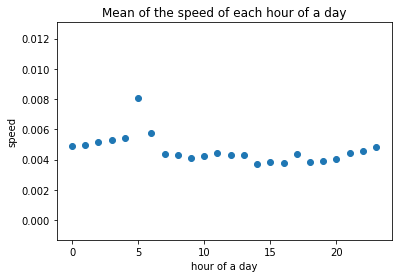

In [44]:
plt.scatter(swm.index,swm.speed)
ymin=min(swm.speed)-0.005
ymax=max(swm.speed)+0.005
plt.ylim([ymin,ymax])
plt.xlabel('hour of a day')
plt.ylabel('speed')
plt.title('Mean of the speed of each hour of a day')

## Comments:
Hypothesis of speed as hour of a day :The largest speed appear between 4am~6am. which is the time period have lightest trafic. The the speed quick drop betwwen 7am~9am, and this is the time people go to wrok. Druing the work of a day 10am~15pm, the average speed slight went up. After work, from 18pm to 4 am of next day, the average speed linear increasing. 


While the speed is highly dependent on tracfic, which related with hour of a day and also route. so i will explore the model of speed with pickup, dropoff location and time of a day. 

In [45]:
variable=['Pickup_latitude','Pickup_longitude','Dropoff_longitude','Dropoff_latitude','pickup_hour']

speed_x=df_speed[variable].values

# convert speed into per hour
speed_y=df_speed['speed'].values*3600

Text(0.5,1,'histogram of speed')

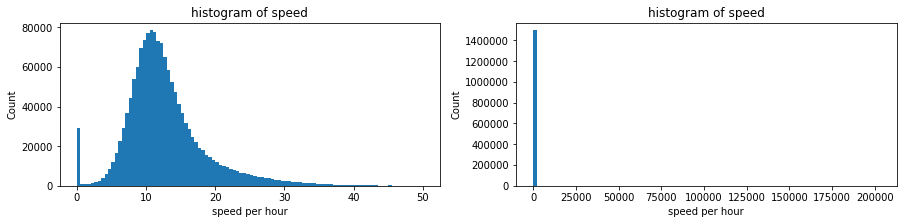

In [46]:
plt.figure(figsize=(15,3))
plt.subplot(121)
plt.hist(speed_y,bins=100,range=(0,50));
plt.xlabel('speed per hour')
plt.ylabel('Count')
plt.title('histogram of speed')
plt.subplot(122)
plt.hist(speed_y,bins=100);
plt.xlabel('speed per hour')
plt.ylabel('Count')
plt.title('histogram of speed')

## Comments: 
The data speed_per_hour is slightly positive skewed Gaussian distribution except speed of 0. I assume trip_distance unit is km. so the velocity >50km/hour is not reasonable. These part of data are anomaly. so remove this part before model training. 

c:\program files\python36\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


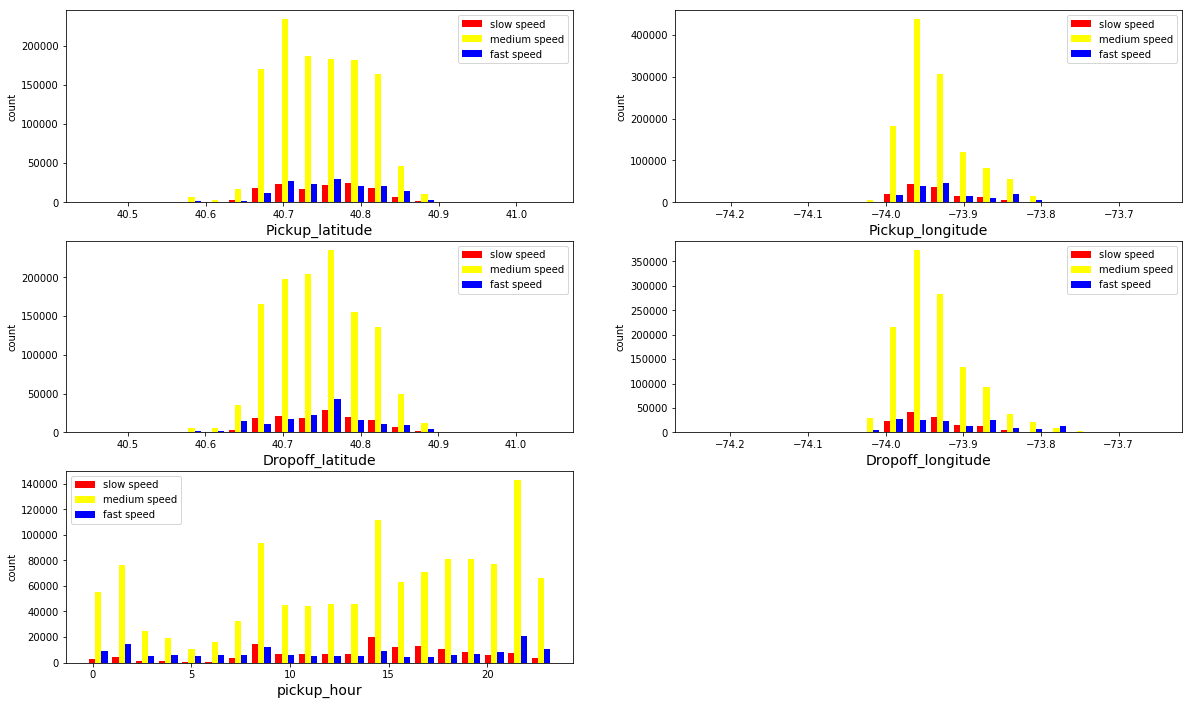

In [47]:
variable=['Pickup_latitude','Pickup_longitude','Dropoff_longitude','Dropoff_latitude','pickup_hour','speed']
speed_model=df_speed[variable]
plot_speed_time_location(speed_model)

## Comments: 
1, The histogram of pickup_latitude and drop_off latitude are closed to uniformly distribtuted;

2, The histogram of pickup_longtitude and dropoff longtidutite are more focused on -74~-73.9. 

2, The histogram of pickup_hour indicate that between 21pm ~6am, the number of fast_speed (blue) is much larger than number of slow_speed (red), While at 15pm, the number of slow_speed is larger than number of fast speed. this is consistent with plot of average_speed of each hour of a day (out[45])

3, My assumption is that the pickup_hour is most important factor for determining speed. 

In [48]:
# using adaboost ensembel model to explore the assumption in last comment:

variable=['Pickup_latitude','Pickup_longitude','Dropoff_latitude','Dropoff_longitude','pickup_hour','speed']

speed_model=df_speed[variable]
speed_anormal=speed_model[speed_model['speed']>50/3600]
speed_normal=speed_model[speed_model['speed']<=50/3600]

speed_x=speed_normal.iloc[:,:-1].values
speed_y=speed_normal.iloc[:,-1].values*3600

In [49]:
train_speed_x,test_speed_x,train_speed_y,test_speed_y=train_test_split(speed_x,speed_y,test_size=0.2,random_state=100)

In [50]:
lm_speed=AdaBoostRegressor()
lm_speed.fit(train_speed_x,train_speed_y)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)

In [51]:
y_predict_speed=lm_speed.predict(test_speed_x)

In [52]:
print('The mean square error is {0:.2f}'.format(mean_squared_error(test_speed_y,y_predict_speed)))

The mean square error is 39.83


In [53]:
for i in range(5):
    print('The feature importance of {0} of adaboost model is {1:.2f}'.format(variable[i],lm_speed.feature_importances_[i]))


The feature importance of Pickup_latitude of adaboost model is 0.12
The feature importance of Pickup_longitude of adaboost model is 0.24
The feature importance of Dropoff_latitude of adaboost model is 0.14
The feature importance of Dropoff_longitude of adaboost model is 0.36
The feature importance of pickup_hour of adaboost model is 0.14


## Comments: 
1, The error of speed of test data is 37.04, while range of speed is 0~50. so the model performance not very well. The feature show that most important feature is dropoff_long, which rejected my assumption in last comments. I assume the reason behind this is the pickup, dropoff location and pickup_hour are not indenpent variable . The feature engineer need to be reconsidered for building speed model 
